# Goals

- The main goal of this project is to make a prediction of stock prices of PETR4.
- Additionally, I would like to work with 2-month predictions in order to figure out a way to find out nice opportunities for options on this stock. PETR4 options are amidst the most traded in the world.
- An extension to this project would be to build a bot to trade this stock.

## How

- First I'm going to make use of time series with the daily stock prices, probably LSTM or bidirectional LSTM, which are the most relevant. 
- Maybe I could try to put another variable like international price of oil or other oil stocks.

# Getting Data

In [1]:
#!pip install yfinance

In [41]:
import yfinance as yf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
papel = yf.Ticker('PETR4.SA')
papel

yfinance.Ticker object <PETR4.SA>

In [3]:
dados= papel.history(start= '2007-01-01', end='2022-12-29')

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3966 entries, 2007-01-02 00:00:00-02:00 to 2022-12-28 00:00:00-03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3966 non-null   float64
 1   High          3966 non-null   float64
 2   Low           3966 non-null   float64
 3   Close         3966 non-null   float64
 4   Volume        3966 non-null   int64  
 5   Dividends     3966 non-null   float64
 6   Stock Splits  3966 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 247.9 KB


# Exploratory Analysis

In [5]:
# Close price through the years

<AxesSubplot:xlabel='Date'>

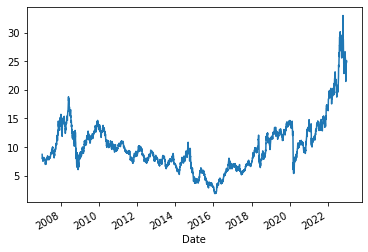

In [6]:
dados['Close'].plot()

In [7]:
# dividend distribution

In [8]:
div=dados[['Dividends']]
div=div[div['Dividends']>0]
div.head()

,Dividends
Date,
2007-01-02 00:00:00-02:00,0.2250
2007-04-03 00:00:00-03:00,0.1750
2007-08-20 00:00:00-03:00,0.2517
2007-10-08 00:00:00-03:00,0.2565
2008-01-14 00:00:00-02:00,0.1553


In [9]:
div.index

DatetimeIndex(['2007-01-02 00:00:00-02:00', '2007-04-03 00:00:00-03:00',
               '2007-08-20 00:00:00-03:00', '2007-10-08 00:00:00-03:00',
               '2008-01-14 00:00:00-02:00', '2008-04-07 00:00:00-03:00',
               '2008-12-29 00:00:00-02:00', '2009-04-09 00:00:00-03:00',
               '2009-07-06 00:00:00-03:00', '2009-10-01 00:00:00-03:00',
               '2009-12-21 00:00:00-02:00', '2010-04-23 00:00:00-03:00',
               '2010-05-24 00:00:00-03:00', '2010-08-02 00:00:00-03:00',
               '2010-11-03 00:00:00-02:00', '2010-12-22 00:00:00-02:00',
               '2011-03-22 00:00:00-03:00', '2011-04-29 00:00:00-03:00',
               '2011-05-12 00:00:00-03:00', '2011-08-03 00:00:00-03:00',
               '2011-11-14 00:00:00-02:00', '2012-01-03 00:00:00-02:00',
               '2012-03-20 00:00:00-03:00', '2012-05-14 00:00:00-03:00',
               '2013-04-30 00:00:00-03:00', '2014-04-03 00:00:00-03:00',
               '2018-05-22 00:00:00-03:00', '2018-0

In [10]:
#for date in div.index:
    #print(date)

In [11]:
div.index[0]

Timestamp('2007-01-02 00:00:00-0200', tz='America/Sao_Paulo')

In [12]:
dados.index.get_loc(div.index[2])

157

In [13]:
dados.index.get_loc('2007-08-20 00:00:00-03:00')

157

In [14]:
dados.iloc[157]

Open            8.221955e+00
High            8.241330e+00
Low             8.031730e+00
Close           8.149740e+00
Volume          2.473800e+07
Dividends       2.517000e-01
Stock Splits    0.000000e+00
Name: 2007-08-20 00:00:00-03:00, dtype: float64

In [15]:
locations_div=[]
for data in div.index:
    locations_div.append(dados.index.get_loc(data))

In [16]:
close_div=[]
for loc in locations_div:
    close_div.append(dados.iloc[loc]['Close'])

In [17]:
div['Price']=close_div

In [18]:
div['DY']=div['Dividends']/div['Price']

In [19]:
div

,Dividends,Price,DY
Date,,,
2007-01-02 00:00:00-02:00,0.225000,8.701064,0.025859
2007-04-03 00:00:00-03:00,0.175000,7.908744,0.022127
2007-08-20 00:00:00-03:00,0.251700,8.149740,0.030884
2007-10-08 00:00:00-03:00,0.256500,10.987377,0.023345
2008-01-14 00:00:00-02:00,0.155300,14.462688,0.010738
2008-04-07 00:00:00-03:00,0.102600,14.037206,0.007309
2008-12-29 00:00:00-02:00,0.042600,8.069036,0.005279
2009-04-09 00:00:00-03:00,0.351600,11.181715,0.031444
2009-07-06 00:00:00-03:00,0.300000,10.998055,0.027278


<AxesSubplot:xlabel='Date'>

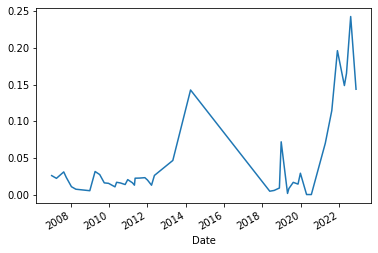

In [20]:
div['DY'].plot()

In [21]:
#!git add .
#!git commit -m 'petro analysis'
#!git push origin main

# Model example

## Previous time series project

- for information, i copied this from a previous rnn project

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

def initialize_model():
    model = Sequential()
    model.add(SimpleRNN(units=20,activation='tanh',input_shape=(3966, 1)))
    model.add(Dense(10,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    
    return model

model=initialize_model()
model.summary()

2023-01-12 10:41:19.484069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 10:41:19.484144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


2023-01-12 10:41:27.458575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 10:41:27.458706: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 10:41:27.458916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-23E8V41): /proc/driver/nvidia/version does not exist
2023-01-12 10:41:27.459227: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
'''
def compile_model(model):
    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])
    return model
model=compile_model(model)

model = compile_model(initialize_model())

model.fit(X_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)]
)
'''

"\ndef compile_model(model):\n    model.compile(loss='mse',optimizer='rmsprop',metrics=['mae'])\n    return model\nmodel=compile_model(model)\n\nmodel = compile_model(initialize_model())\n\nmodel.fit(X_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,\n          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)]\n)\n"

## LSTM for stocks

- Found this on the internet. Very good base example of a LSTM stock prediction.

In [24]:
#https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

In [25]:
import math
from sklearn.preprocessing import MinMaxScaler 
import numpy as np

close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]


#train set

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#test set
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
#model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
98/98 [==============================] - 17s 127ms/step - loss: 0.0024
Epoch 2/3
98/98 [==============================] - 11s 116ms/step - loss: 2.6413e-04
Epoch 3/3
98/98 [==============================] - 12s 117ms/step - loss: 2.5152e-04


In [28]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.4298680535180572

/tmp/ipykernel_475/2686380006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


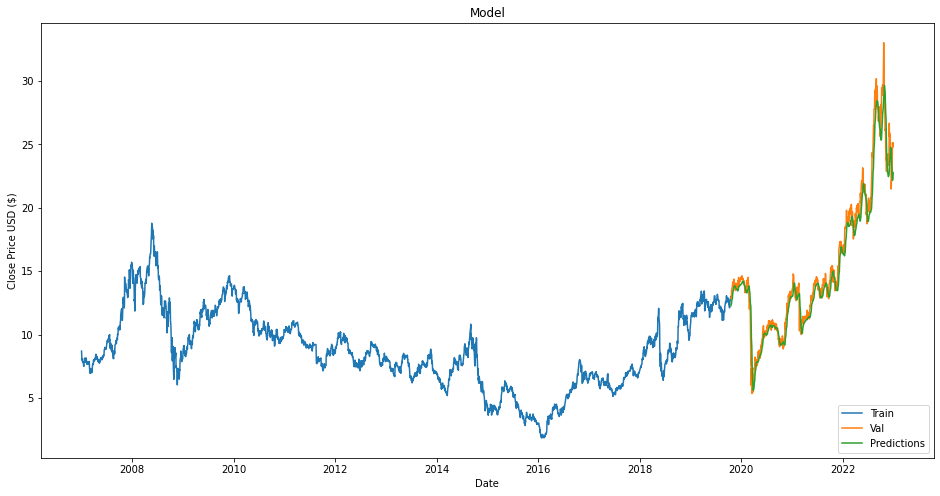

In [29]:
import matplotlib.pyplot as plt

data = dados.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/tmp/ipykernel_475/1626216995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


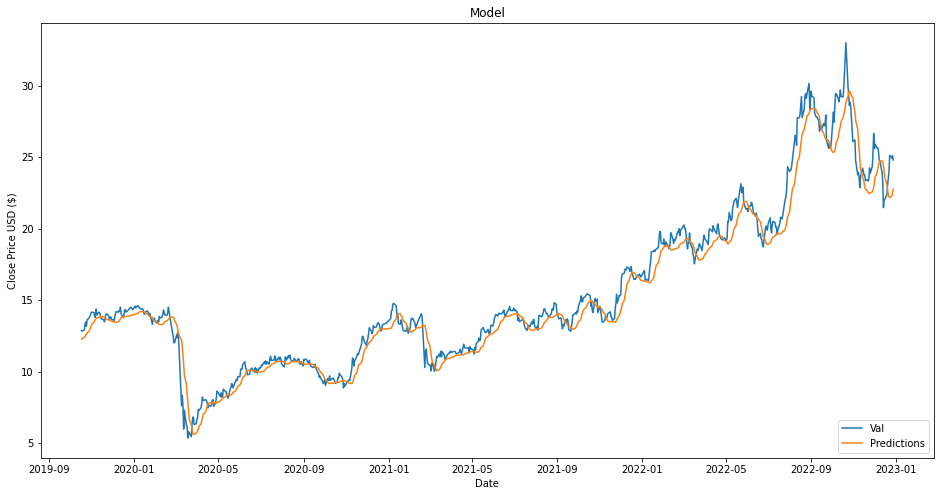

In [30]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [31]:
#according to comments there is data leakage in the scaling process.

# Fixing Data leaking

In [13]:
import math
from sklearn.preprocessing import MinMaxScaler 
import numpy as np

close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

values=values.reshape(-1,1)
train_values=values[0: training_data_len]

scaler = MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_values)

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
test_values=values[training_data_len-60:]

test_data = scaler.transform(test_values)
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
x_test.shape

(793, 60, 1)

In [37]:
y_test.shape

(793, 1)

In [38]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
98/98 [==============================] - 18s 140ms/step - loss: 0.0062
Epoch 2/3
98/98 [==============================] - 12s 119ms/step - loss: 8.9274e-04
Epoch 3/3
98/98 [==============================] - 12s 118ms/step - loss: 8.2907e-04


In [39]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.3701809694306998

/tmp/ipykernel_475/4044787029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


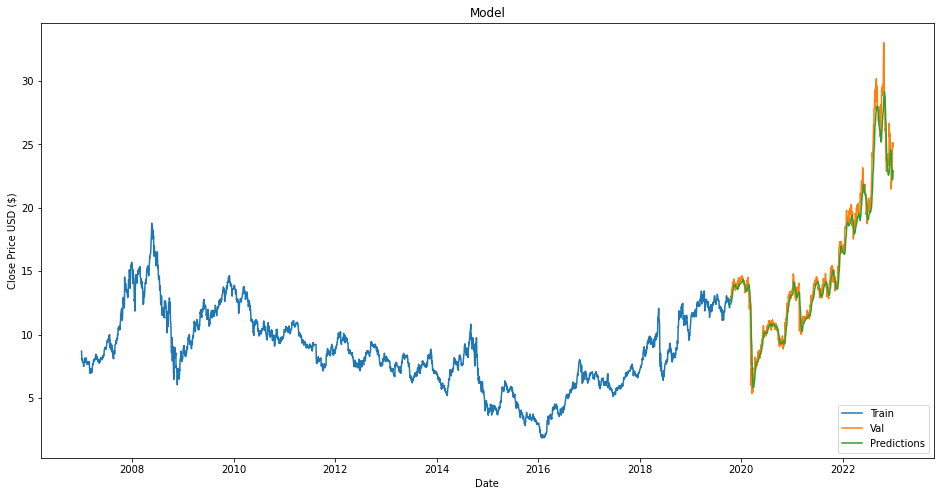

In [40]:
data = dados.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/tmp/ipykernel_475/1626216995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


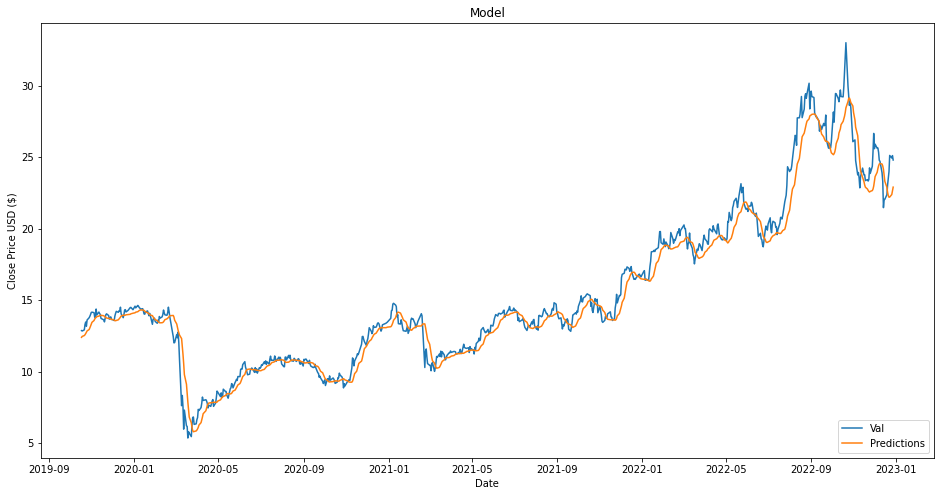

In [41]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [42]:
#looks the same to me. But I'd say its better to not leak data.

In [43]:
#!git add .
#!git commit -m 'first lstm pred'
#!git push origin main

# Baseline model

- I've figured out how to start building up a model with LSTM
- Now, let's find a baseline to compare how good this actually is
- An idea of baseline is to say that the price on d+1 is going to be the same price on d+0

In [44]:
baseline = pd.DataFrame(y_test).rename(columns={0:'d+0'})
baseline

,d+0
0,12.872649
1,12.844728
2,12.923843
3,13.296153
4,13.473003
...,...
788,23.990000
789,25.120001
790,24.940001
791,25.110001


In [45]:
baseline['d-1']=pd.DataFrame(dados['Close'].values[-794:-1])

In [46]:
baseline

,d+0,d-1
0,12.872649,12.998303
1,12.844728,12.872649
2,12.923843,12.844728
3,13.296153,12.923843
4,13.473003,13.296153
...,...,...
788,23.990000,23.570000
789,25.120001,23.990000
790,24.940001,25.120001
791,25.110001,24.940001


## calculate metrics to beat

In [47]:
rmse_base = np.sqrt(np.mean((baseline['d+0']-baseline['d-1'])**2))
rmse_base

0.4619846356177066

In [48]:
#!git add .
#!git commit -m 'baseline'
#!git push origin main

# Tuning the model

In [52]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=32, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/30
78/78 [==============================] - 20s 187ms/step - loss: 0.0118 - val_loss: 0.0011
Epoch 2/30
78/78 [==============================] - 11s 140ms/step - loss: 9.2286e-04 - val_loss: 9.8158e-04
Epoch 3/30
78/78 [==============================] - 10s 131ms/step - loss: 8.4345e-04 - val_loss: 8.9050e-04
Epoch 4/30
78/78 [==============================] - 10s 129ms/step - loss: 7.4385e-04 - val_loss: 7.7596e-04
Epoch 5/30
78/78 [==============================] - 10s 132ms/step - loss: 7.6381e-04 - val_loss: 8.0452e-04
Epoch 6/30
78/78 [==============================] - 10s 129ms/step - loss: 6.8358e-04 - val_loss: 6.4221e-04
Epoch 7/30
78/78 [==============================] - 10s 133ms/step - loss: 6.4111e-04 - val_loss: 6.1409e-04
Epoch 8/30
78/78 [==============================] - 10s 131ms/step - loss: 5.8217e-04 - val_loss: 5.6382e-04
Epoch 9/30
78/78 [==============================] - 10s 130ms/step - loss: 5.8851e-04 - val_loss: 6.2490e-04
Epoch 10/30
78/78 [========

In [53]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.35588165249529885

In [54]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=32, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
78/78 [==============================] - 15s 144ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 2/100
78/78 [==============================] - 10s 129ms/step - loss: 8.8703e-04 - val_loss: 0.0010
Epoch 3/100
78/78 [==============================] - 10s 129ms/step - loss: 8.5167e-04 - val_loss: 9.0434e-04
Epoch 4/100
78/78 [==============================] - 11s 138ms/step - loss: 7.8797e-04 - val_loss: 9.0318e-04
Epoch 5/100
78/78 [==============================] - 10s 131ms/step - loss: 7.2772e-04 - val_loss: 7.4551e-04
Epoch 6/100
78/78 [==============================] - 10s 131ms/step - loss: 6.3948e-04 - val_loss: 7.5316e-04
Epoch 7/100
78/78 [==============================] - 10s 130ms/step - loss: 6.7882e-04 - val_loss: 6.0381e-04
Epoch 8/100
78/78 [==============================] - 10s 130ms/step - loss: 5.8213e-04 - val_loss: 5.6239e-04
Epoch 9/100
78/78 [==============================] - 10s 131ms/step - loss: 5.4426e-04 - val_loss: 5.0237e-04
Epoch 10/100
78/78 [==

In [55]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.11015652648136866

In [56]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=30,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/30
156/156 [==============================] - 22s 114ms/step - loss: 0.0042 - val_loss: 9.1746e-04
Epoch 2/30
156/156 [==============================] - 17s 107ms/step - loss: 8.2186e-04 - val_loss: 0.0012
Epoch 3/30
156/156 [==============================] - 17s 108ms/step - loss: 8.4441e-04 - val_loss: 6.1654e-04
Epoch 4/30
156/156 [==============================] - 17s 107ms/step - loss: 6.5513e-04 - val_loss: 5.4560e-04
Epoch 5/30
156/156 [==============================] - 17s 107ms/step - loss: 5.9395e-04 - val_loss: 5.2214e-04
Epoch 6/30
156/156 [==============================] - 17s 106ms/step - loss: 5.2290e-04 - val_loss: 5.4951e-04
Epoch 7/30
156/156 [==============================] - 17s 108ms/step - loss: 4.7423e-04 - val_loss: 7.7003e-04
Epoch 8/30
156/156 [==============================] - 17s 107ms/step - loss: 5.4118e-04 - val_loss: 3.5692e-04
Epoch 9/30
156/156 [==============================] - 17s 107ms/step - loss: 3.8944e-04 - val_loss: 3.1891e-04
Epoch 10/

In [57]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.12226908384325526

In [49]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
156/156 [==============================] - 22s 115ms/step - loss: 0.0058 - val_loss: 9.9980e-04
Epoch 2/100
156/156 [==============================] - 16s 105ms/step - loss: 9.0083e-04 - val_loss: 9.0247e-04
Epoch 3/100
156/156 [==============================] - 16s 105ms/step - loss: 8.2640e-04 - val_loss: 8.6524e-04
Epoch 4/100
156/156 [==============================] - 17s 108ms/step - loss: 7.3999e-04 - val_loss: 9.7815e-04
Epoch 5/100
156/156 [==============================] - 17s 108ms/step - loss: 7.5139e-04 - val_loss: 5.6287e-04
Epoch 6/100
156/156 [==============================] - 17s 109ms/step - loss: 5.9002e-04 - val_loss: 5.2592e-04
Epoch 7/100
156/156 [==============================] - 17s 106ms/step - loss: 5.5462e-04 - val_loss: 4.9390e-04
Epoch 8/100
156/156 [==============================] - 17s 109ms/step - loss: 4.6327e-04 - val_loss: 3.8415e-04
Epoch 9/100
156/156 [==============================] - 16s 106ms/step - loss: 4.4826e-04 - val_loss: 3.7604e

In [50]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.17183584884316444

## saving best model

In [ ]:
#saving best model

In [52]:
import pickle
filename = 'model1.sav'
#pickle.dump(model, open(filename, 'wb'))

In [53]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred=loaded_model.predict(x_test)
y_pred=scaler.inverse_transform(y_pred)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.000299976271909543

## plotting prediction

In [54]:
predict = pd.DataFrame(y_test).rename(columns={0:'actual'})
predict['pred']=pd.DataFrame(y_pred)
predict

,actual,pred
0,12.872649,13.046600
1,12.844728,12.904234
2,12.923843,12.879878
3,13.296153,12.970884
4,13.473003,13.368046
...,...,...
788,23.990000,23.657974
789,25.120001,24.065161
790,24.940001,25.578205
791,25.110001,24.542374


/tmp/ipykernel_475/4035412964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = y_pred


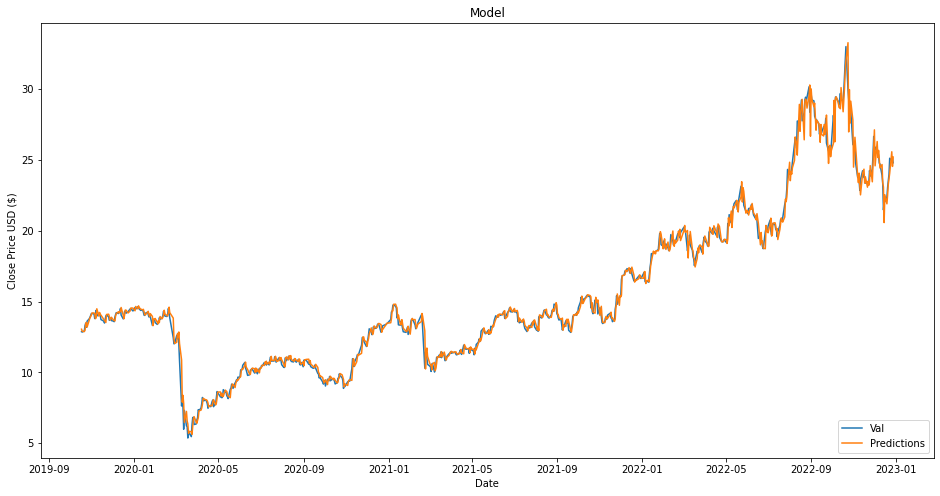

In [55]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = y_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [77]:
#!git add .
#!git commit -m 'Nice model'
#!git push origin main

# Building up on that model

In [56]:
#There are two things I could do right now. Change the output and increase the input data
#Increasing the input data from 60 days to something else should be easier, so lets start by that.

## Increasing input data

In [57]:
#Currently the model takes the 60 previous days to make a prediction of the following day.
#This might not be enough if we think about a prediction of a week or a prediction of 2 months.
#So lets start by making it 90 days.

In [15]:
close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

In [16]:
print(values.shape)
values

(3966,)


array([ 8.7010622 ,  8.43650341,  8.24802589, ..., 24.94000053,
       25.11000061, 24.79999924])

In [17]:
values=values.reshape(-1,1)
print(values.shape)
values

(3966, 1)


array([[ 8.7010622 ],
       [ 8.43650341],
       [ 8.24802589],
       ...,
       [24.94000053],
       [25.11000061],
       [24.79999924]])

In [18]:
train_values=values[0: training_data_len]
#test_values=values[training_data_len:]

In [19]:
train_values.shape

(3173, 1)

In [20]:
#test_values.shape

In [21]:
#Scaling data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_values)

In [22]:
#training data
x_train = []
y_train = []

for i in range(90, len(train_data)):
    #cada resultado i tem 90 dias pra trás como features
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])

In [23]:
x_train, y_train = np.array(x_train), np.array(y_train)
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape #(3173-90)

(3083, 90)

In [24]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #expand dims pra entrar no modelo
x_train.shape

(3083, 90, 1)

In [25]:
#test data

In [26]:
test_values=values[training_data_len-90:] #vou precisar de 90 dias antes pra fazer o modelo

test_data = scaler.transform(test_values)

x_test = []
y_test = values[training_data_len:] #shape diferente pra passar no scaler

for i in range(90, len(test_data)):
  x_test.append(test_data[i-90:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
y_test.shape

(793, 1)

In [28]:
y_train.shape

(3083,)

In [29]:
y_train_2=values[90:training_data_len]
y_train_2.shape #both work

(3083, 1)

In [30]:
x_test.shape

(793, 90, 1)

In [ ]:
#lets run a model with more input data

In [101]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
155/155 [==============================] - 31s 173ms/step - loss: 0.0035 - val_loss: 9.2399e-04
Epoch 2/100
155/155 [==============================] - 25s 160ms/step - loss: 8.0585e-04 - val_loss: 7.3247e-04
Epoch 3/100
155/155 [==============================] - 25s 160ms/step - loss: 7.1075e-04 - val_loss: 0.0021
Epoch 4/100
155/155 [==============================] - 25s 160ms/step - loss: 6.3230e-04 - val_loss: 9.1949e-04
Epoch 5/100
155/155 [==============================] - 24s 153ms/step - loss: 5.2162e-04 - val_loss: 4.5046e-04
Epoch 6/100
155/155 [==============================] - 24s 156ms/step - loss: 4.7804e-04 - val_loss: 6.3618e-04
Epoch 7/100
155/155 [==============================] - 24s 153ms/step - loss: 4.6510e-04 - val_loss: 3.5192e-04
Epoch 8/100
155/155 [==============================] - 24s 154ms/step - loss: 3.8855e-04 - val_loss: 3.1697e-04
Epoch 9/100
155/155 [==============================] - 24s 152ms/step - loss: 3.8481e-04 - val_loss: 3.8900e-04


In [102]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.13690735142288113

In [103]:
#ok, so making it 90 days or whatever days is pretty forward.
#lets work on changing the output

In [167]:
#!git add .
#!git commit -m '90 days input'
#!git push origin main

## Changing output

In [104]:
#there is two ways to change the output. One is a single day in a week or a month.
#the other is the full range of weeks. I could try that, but I think its more complicated and pointless.
#maybe just to practice my lstm skills.

In [31]:
#changing the output is basically changing the ytrain and ytest

#training data
x_train = []
y_train = []

for i in range(90, (len(train_data)-6)):
    #cada resultado i tem 90 dias pra trás como features
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i+6, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #expand dims pra entrar no modelo
print(x_train.shape)
print(y_train.shape)

(3077, 90, 1)
(3077,)


In [32]:
test_values=values[training_data_len-90:] #vou precisar de 90 dias antes pra fazer o modelo

test_data = scaler.transform(test_values)

x_test = []
y_test = values[training_data_len:-6] 

for i in range(90, (len(test_data)-6)):
  x_test.append(test_data[i-90:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)
print(y_test.shape)

(787, 90, 1)
(787, 1)


In [33]:
values[89+7]

array([8.2066927])

In [34]:
y_train.reshape(-1,1)

array([[0.37545301],
       [0.36495452],
       [0.37133595],
       ...,
       [0.64145524],
       [0.64942768],
       [0.65849978]])

In [35]:
scaler.inverse_transform(y_train.reshape(-1,1))

array([[ 8.2066927 ],
       [ 8.0289669 ],
       [ 8.13699627],
       ...,
       [12.70976448],
       [12.84472752],
       [12.99830627]])

In [150]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])


Epoch 1/100
154/154 [==============================] - 28s 155ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 2/100
154/154 [==============================] - 23s 148ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 3/100
154/154 [==============================] - 25s 164ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 4/100
154/154 [==============================] - 23s 152ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/100
154/154 [==============================] - 23s 149ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 6/100
154/154 [==============================] - 24s 156ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/100
154/154 [==============================] - 24s 154ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/100
154/154 [==============================] - 24s 155ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/100
154/154 [==============================] - 23s 150ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/100
154/154 [==============================] - 24s 155m

In [151]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.2691821015926298

In [168]:
#!git add .
#!git commit -m '7 day prediction'
#!git push origin main

## How many days do I really want?

- we could go for a monthly rate of the stock, that would be interesting
- but the main goal was to predict the price of the options of petr4, which happen every two months.


- how many days are there between options?
https://www.b3.com.br/data/files/30/C3/24/BA/4FA6161025668616790D8AA8/PREGOES.pdf
- 46 pregoes (data points)

In [153]:
#media de pregoes
preg = (248+249+247+248+248+245+246+249+246+248+248)/10
preg

272.2

In [155]:
round(preg/12)

23

- Increasing the input as well for a year seems correct.
- 272 Pregoes (data points)

# Prediction 60 days

In [51]:
close_prices = dados['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

values=values.reshape(-1,1)
train_values=values[0: training_data_len]

#Scaling data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_values)

#training data
x_train = []
y_train = []

for i in range(272, len(train_data)-45):
    #cada resultado i tem 272 dias pra trás como features
    x_train.append(train_data[i-272:i, 0])
    y_train.append(train_data[i+45, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #expand dims pra entrar no modelo
print(x_train.shape)
print(y_train.shape)



test_values=values[training_data_len-272:] #vou precisar de 90 dias antes pra fazer o modelo

test_data = scaler.transform(test_values)

x_test = []
y_test = values[training_data_len:-45] 

for i in range(272, (len(test_data)-45)):
  x_test.append(test_data[i-272:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)
print(y_test.shape)

(2856, 272, 1)
(2856,)
(748, 272, 1)
(748, 1)


In [37]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

2023-01-19 11:51:20.096625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-19 11:51:20.097590: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-19 11:51:20.098225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-23E8V41): /proc/driver/nvidia/version does not exist
2023-01-19 11:51:20.105671: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
143/143 [==============================] - 69s 451ms/step - loss: 0.0123 - val_loss: 0.0086
Epoch 2/100
143/143 [==============================] - 76s 530ms/step - loss: 0.0087 - val_loss: 0.0121
Epoch 3/100
143/143 [==============================] - 62s 434ms/step - loss: 0.0090 - val_loss: 0.0127
Epoch 4/100
143/143 [==============================] - 62s 430ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 5/100
143/143 [==============================] - 62s 431ms/step - loss: 0.0086 - val_loss: 0.0112
Epoch 6/100
143/143 [==============================] - 62s 431ms/step - loss: 0.0085 - val_loss: 0.0087


In [43]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.9912195416057812

In [44]:
predictions

array([[11.421278 ],
       [11.457005 ],
       [11.490691 ],
       [11.5243025],
       [11.571546 ],
       [11.632471 ],
       [11.686466 ],
       [11.750777 ],
       [11.825025 ],
       [11.905729 ],
       [11.990977 ],
       [12.08024  ],
       [12.167716 ],
       [12.247586 ],
       [12.304134 ],
       [12.343417 ],
       [12.392508 ],
       [12.428495 ],
       [12.46221  ],
       [12.488229 ],
       [12.505482 ],
       [12.504452 ],
       [12.487354 ],
       [12.455095 ],
       [12.435873 ],
       [12.429132 ],
       [12.426069 ],
       [12.414928 ],
       [12.4017515],
       [12.39193  ],
       [12.377483 ],
       [12.359231 ],
       [12.337797 ],
       [12.32882  ],
       [12.336203 ],
       [12.359642 ],
       [12.389327 ],
       [12.425626 ],
       [12.46323  ],
       [12.510494 ],
       [12.542032 ],
       [12.550212 ],
       [12.551297 ],
       [12.561408 ],
       [12.578433 ],
       [12.592201 ],
       [12.607656 ],
       [12.63

In [50]:
pred1 = pd.DataFrame(y_test).rename(columns={0:'actual'})
pred1['pred']=pd.DataFrame(predictions)
pred1

,actual,pred
0,12.872652,11.421278
1,12.844728,11.457005
2,12.923843,11.490691
3,13.296152,11.524302
4,13.473003,11.571546
...,...,...
743,29.931961,22.085045
744,30.990646,22.201563
745,31.909344,22.350262
746,33.003029,22.541759


/tmp/ipykernel_24260/2387409059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


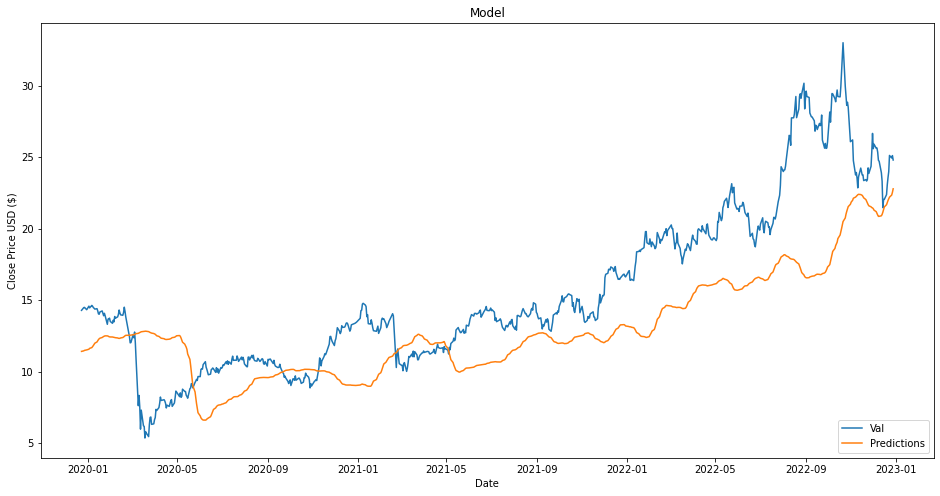

In [48]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len+45:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [52]:
#Its not good. The model is not able to correctly predict the next 45 days based on the last year.
#improve the model
#increase variables

In [169]:
#!git add .
#!git commit -m '60days'
#!git push origin main

# Improving new model

In [61]:
#Lets try to finetune the existing model to improve our results

model = Sequential()
model.add(LSTM(300, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(75))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
143/143 [==============================] - 240s 2s/step - loss: 0.0109 - val_loss: 0.0103
Epoch 2/100
143/143 [==============================] - 179s 1s/step - loss: 0.0090 - val_loss: 0.0066
Epoch 3/100
143/143 [==============================] - 159s 1s/step - loss: 0.0087 - val_loss: 0.0059
Epoch 4/100
143/143 [==============================] - 161s 1s/step - loss: 0.0088 - val_loss: 0.0119
Epoch 5/100
143/143 [==============================] - 158s 1s/step - loss: 0.0089 - val_loss: 0.0078
Epoch 6/100
143/143 [==============================] - 157s 1s/step - loss: 0.0085 - val_loss: 0.0104
Epoch 7/100
143/143 [==============================] - 161s 1s/step - loss: 0.0088 - val_loss: 0.0090
Epoch 8/100
143/143 [==============================] - 158s 1s/step - loss: 0.0085 - val_loss: 0.0087


In [62]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.8751134056458498

In [68]:
#biderectional
from tensorflow.keras.layers import Bidirectional

#Lets try to finetune the existing model to improve our results

model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=True, input_shape=(x_train.shape[1], 1))))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dense(75))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train,y_train, batch_size=16, epochs=100,verbose=1,validation_split=0.2,
          callbacks=[EarlyStopping(patience=5,restore_best_weights=True)])

Epoch 1/100
143/143 [==============================] - 339s 2s/step - loss: 0.0109 - val_loss: 0.0123
Epoch 2/100
143/143 [==============================] - 299s 2s/step - loss: 0.0088 - val_loss: 0.0092
Epoch 3/100
143/143 [==============================] - 295s 2s/step - loss: 0.0082 - val_loss: 0.0116
Epoch 4/100
143/143 [==============================] - 298s 2s/step - loss: 0.0083 - val_loss: 0.0139
Epoch 5/100
143/143 [==============================] - 300s 2s/step - loss: 0.0086 - val_loss: 0.0111
Epoch 6/100
143/143 [==============================] - 295s 2s/step - loss: 0.0081 - val_loss: 0.0154
Epoch 7/100
143/143 [==============================] - 297s 2s/step - loss: 0.0080 - val_loss: 0.0070
Epoch 8/100
143/143 [==============================] - 308s 2s/step - loss: 0.0079 - val_loss: 0.0119
Epoch 9/100
143/143 [==============================] - 294s 2s/step - loss: 0.0077 - val_loss: 0.0145
Epoch 10/100
143/143 [==============================] - 299s 2s/step - loss: 0.007

In [69]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.5670996815125573

/tmp/ipykernel_24260/2387409059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


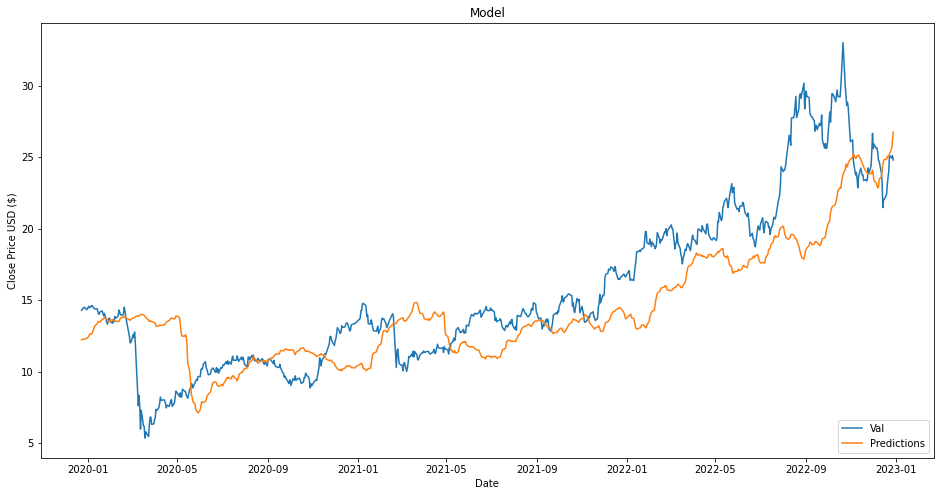

In [70]:
data = dados.filter(['Close'])
#train = data[:training_data_len]
validation = data[training_data_len+45:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
#plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import pickle
filename = 'modelbidirectional.sav'
pickle.dump(model, open(filename, 'wb'))

2023-01-19 15:13:20.446279: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred=loaded_model.predict(x_test)
y_pred=scaler.inverse_transform(y_pred)
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse